In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# SUBJECT 1

In [7]:
# Load the uploaded force data file
file_path = r"C:\Users\opeye\Desktop\ALL GAIT DATA\SUBJECT 1\GP1_0.6_force.csv"
force_data = pd.read_csv(file_path)

# Display the first few rows
print(force_data.head())

   FP1_x     FP2_x  FP1_y      FP2_y  FP1_z       FP2_z
0    0.0 -9.537293    0.0  30.241894    0.0  777.790222
1    0.0 -8.993257    0.0  30.251348    0.0  777.832886
2    0.0 -8.459884    0.0  30.250864    0.0  777.852966
3    0.0 -7.937055    0.0  30.241360    0.0  777.852539
4    0.0 -7.424666    0.0  30.223719    0.0  777.833374


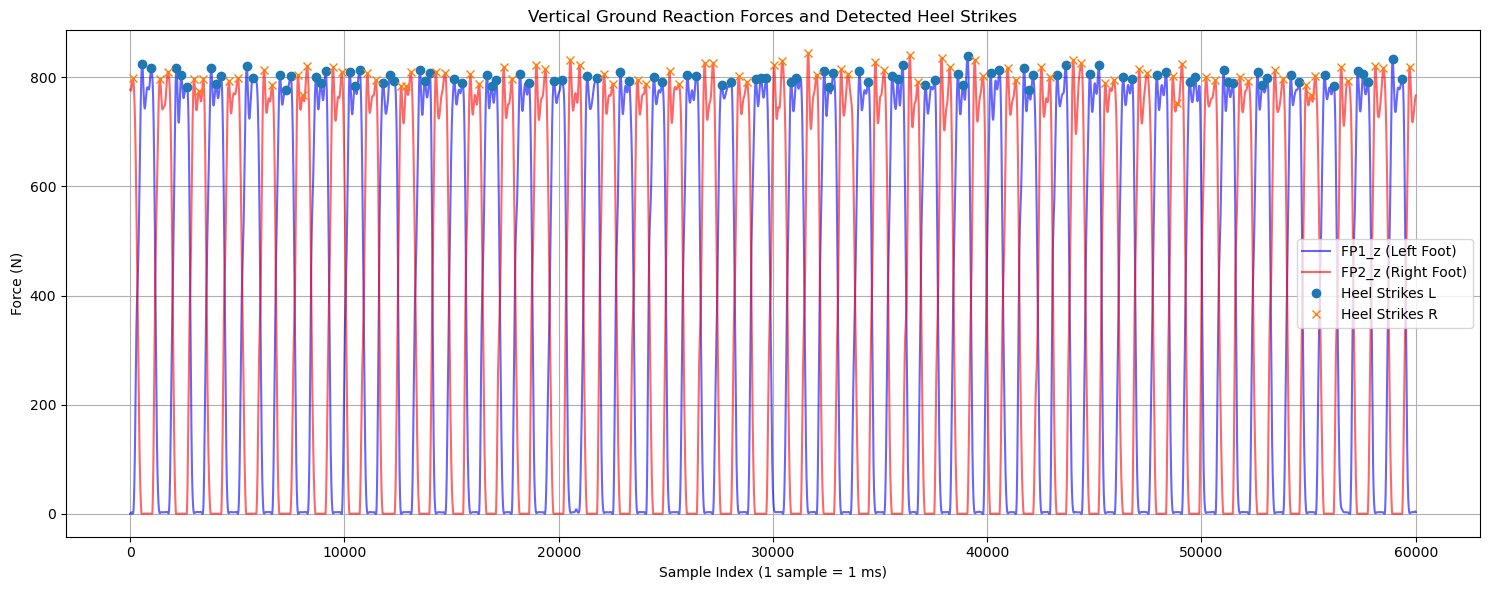

In [8]:
# Extract vertical ground reaction forces
fp1_z = force_data['FP1_z']  # Left foot
fp2_z = force_data['FP2_z']  # Right foot

# Find heel strikes using peak detection on vertical force
# Only consider forces above 100 N to avoid noise
peaks_fp1, _ = find_peaks(fp1_z, height=100, distance=200)
peaks_fp2, _ = find_peaks(fp2_z, height=100, distance=200)

# Plot vertical forces and detected peaks
plt.figure(figsize=(15, 6))
plt.plot(fp1_z, label='FP1_z (Left Foot)', color='blue', alpha=0.6)
plt.plot(fp2_z, label='FP2_z (Right Foot)', color='red', alpha=0.6)
plt.plot(peaks_fp1, fp1_z.iloc[peaks_fp1], 'o', label='Heel Strikes L')
plt.plot(peaks_fp2, fp2_z.iloc[peaks_fp2], 'x', label='Heel Strikes R')
plt.title('Vertical Ground Reaction Forces and Detected Heel Strikes')
plt.xlabel('Sample Index (1 sample = 1 ms)')
plt.ylabel('Force (N)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# STEP TIMING OF SUBJECT 1
step_times_left = pd.Series(peaks_fp1).diff().dropna() / 1000  # in seconds
step_times_left
import numpy as np

# Calculate step timing (in seconds) for both feet
step_times_left = np.diff(peaks_fp1) / 1000  # since sampling rate is 1000 Hz
step_times_right = np.diff(peaks_fp2) / 1000

# Calculate peak forces at heel strikes
peak_forces_left = fp1_z.iloc[peaks_fp1].values
peak_forces_right = fp2_z.iloc[peaks_fp2].values

# Calculate symmetry features (using length-limited versions to match lengths)
min_len = min(len(step_times_left), len(step_times_right), len(peak_forces_left), len(peak_forces_right))
features_df = pd.DataFrame({
    'step_time_left': step_times_left[:min_len],
    'step_time_right': step_times_right[:min_len],
    'peak_force_left': peak_forces_left[:min_len],
    'peak_force_right': peak_forces_right[:min_len],
    'step_time_diff': np.abs(step_times_left[:min_len] - step_times_right[:min_len]),
    'force_asymmetry': np.abs(peak_forces_left[:min_len] - peak_forces_right[:min_len])
})

# Show the first few rows of the feature set
features_df.head()


,step_time_left,step_time_right,peak_force_left,peak_force_right,step_time_diff,force_asymmetry
0,0.424,1.260,825.101379,798.204041,0.836,26.897338
1,1.176,0.381,817.153992,797.201599,0.795,19.952393
2,0.221,1.213,817.774231,810.455017,0.992,7.319214
3,0.264,0.226,803.586792,796.467041,0.038,7.119751
4,1.136,0.207,782.675293,775.374817,0.929,7.300476


In [19]:
import numpy as np

def extract_gait_phase_features(fpz, sampling_rate=1000, threshold=20):
    """
    Extract stance time, swing time, and impulse from vertical force (FPz) signal.
    
    Parameters:
        fpz (array-like): Vertical ground reaction force for one foot (e.g. FP1_z)
        sampling_rate (int): Sampling frequency in Hz (default 1000)
        threshold (float): Force threshold to detect contact (default 20 N)
    
    Returns:
        stance_times (np.array): Duration of stance phases in seconds
        swing_times (np.array): Duration of swing phases in seconds
        impulses (np.array): Force impulse during stance (Ns)
    """
    
    on_ground = fpz > threshold
    transitions = np.diff(on_ground.astype(int))

    # Detect start and end of stance phases
    stance_starts = np.where(transitions == 1)[0]
    stance_ends   = np.where(transitions == -1)[0]

    # Ensure equal number of starts and ends
    min_len = min(len(stance_starts), len(stance_ends))
    stance_starts = stance_starts[:min_len]
    stance_ends = stance_ends[:min_len]

    # Compute stance times
    stance_times = (stance_ends - stance_starts) / sampling_rate

    # Compute swing times (between consecutive stance phases)
    swing_times = (stance_starts[1:] - stance_ends[:-1]) / sampling_rate

    # Compute impulse for each stance phase
    impulses = []
    for start, end in zip(stance_starts, stance_ends):
        impulse = np.trapz(fpz[start:end], dx=1/sampling_rate)
        impulses.append(impulse)
    impulses = np.array(impulses)

    return stance_times, swing_times, impulses


In [20]:
# Left foot (FP1_z)
stance_left, swing_left, impulse_left = extract_gait_phase_features(fp1_z)

# Right foot (FP2_z)
stance_right, swing_right, impulse_right = extract_gait_phase_features(fp2_z)


In [21]:
min_len = min(len(features_df),
              len(stance_left), len(swing_left), len(impulse_left),
              len(stance_right), len(swing_right), len(impulse_right))

features_df = features_df.iloc[:min_len].copy()
features_df['stance_time_left'] = stance_left[:min_len]
features_df['swing_time_left'] = swing_left[:min_len]
features_df['impulse_left'] = impulse_left[:min_len]
features_df['stance_time_right'] = stance_right[:min_len]
features_df['swing_time_right'] = swing_right[:min_len]
features_df['impulse_right'] = impulse_right[:min_len]


In [22]:
features_df.head()

,step_time_left,step_time_right,peak_force_left,peak_force_right,step_time_diff,force_asymmetry,stance_time_left,swing_time_left,impulse_left,stance_time_right,swing_time_right,impulse_right
0,0.424,1.260,825.101379,798.204041,0.836,26.897338,1.149,0.512,667.092531,-0.553,2.162,0.0
1,1.176,0.381,817.153992,797.201599,0.795,19.952393,1.095,0.495,646.403273,-0.548,2.157,0.0
2,0.221,1.213,817.774231,810.455017,0.992,7.319214,1.119,0.530,665.519074,-0.551,2.194,0.0
3,0.264,0.226,803.586792,796.467041,0.038,7.119751,1.125,0.462,662.758870,-0.526,2.121,0.0
4,1.136,0.207,782.675293,775.374817,0.929,7.300476,1.137,0.529,687.981411,-0.576,2.205,0.0


In [23]:
# Load the uploaded marker data file
file_path = r"C:\Users\opeye\Desktop\ALL GAIT DATA\SUBJECT 1\GP1_0.6_marker.csv"
marker_data = pd.read_csv(file_path)

# Display the first few rows
print(marker_data.head())

    L_FCC_x   L_FM1_x   L_FM2_x   L_FM5_x   R_FCC_x   R_FM1_x   R_FM2_x  \
0  1.127087  1.332534  1.328893  1.305142  0.804407  1.017605  1.017485   
1  1.131831  1.337421  1.333921  1.310700  0.802088  1.015296  1.015148   
2  1.136807  1.342521  1.339171  1.316510  0.799617  1.012833  1.012659   
3  1.141961  1.347770  1.344579  1.322506  0.797009  1.010229  1.010033   
4  1.147230  1.353103  1.350078  1.328615  0.794281  1.007500  1.007287   

    R_FM5_x   L_FCC_y   L_FM1_y  ...   R_FM2_y   R_FM5_y   L_FCC_z   L_FM1_z  \
0  0.991847  0.575397  0.587244  ...  0.448289  0.396237  0.090627  0.084655   
1  0.989509  0.575327  0.586249  ...  0.448250  0.396193  0.090195  0.086384   
2  0.987012  0.575228  0.585174  ...  0.448206  0.396145  0.089767  0.088228   
3  0.984370  0.575094  0.584023  ...  0.448160  0.396093  0.089354  0.090171   
4  0.981602  0.574925  0.582801  ...  0.448109  0.396038  0.088963  0.092198   

    L_FM2_z   L_FM5_z   R_FCC_z   R_FM1_z   R_FM2_z   R_FM5_z  
0  0

In [24]:
import numpy as np

def extract_marker_features(marker_data, step_indices, side='R', sampling_rate=200):
    """
    Extract stride length, step width, vertical displacement, and foot velocity
    from marker data for one foot side ('L' or 'R').
    
    Parameters:
        marker_data (DataFrame): Marker positions (L_FCC_x, L_FCC_y, etc.)
        step_indices (list or array): Frame indices of heel strikes (e.g., from force data)
        side (str): 'L' for left or 'R' for right foot
        sampling_rate (int): Marker sampling rate in Hz (default 200)

    Returns:
        stride_lengths (np.array)
        step_widths (np.array)
        vertical_displacements (np.array)
        velocities (np.array)
    """
    x_col = f'{side}_FCC_x'
    y_col = f'{side}_FCC_y'
    z_col = f'{side}_FCC_z'

    stride_lengths = []
    step_widths = []
    vertical_displacements = []
    velocities = []

    for i in range(len(step_indices) - 1):
        i1, i2 = step_indices[i], step_indices[i + 1]

        # Stride Length (x-direction)
        dx = marker_data[x_col].iloc[i2] - marker_data[x_col].iloc[i1]
        stride_lengths.append(abs(dx))

        # Step Width (y-direction, between L and R at same time)
        if side == 'R':
            y_left = marker_data['L_FCC_y'].iloc[i1]
            y_right = marker_data['R_FCC_y'].iloc[i1]
        else:
            y_left = marker_data['L_FCC_y'].iloc[i1]
            y_right = marker_data['R_FCC_y'].iloc[i1]
        step_widths.append(abs(y_right - y_left))

        # Vertical Displacement (z-range between steps)
        z_range = marker_data[z_col].iloc[i1:i2].max() - marker_data[z_col].iloc[i1:i2].min()
        vertical_displacements.append(z_range)

        # Velocity (distance / time)
        distance = np.sqrt(
            (marker_data[x_col].iloc[i2] - marker_data[x_col].iloc[i1])**2 +
            (marker_data[y_col].iloc[i2] - marker_data[y_col].iloc[i1])**2 +
            (marker_data[z_col].iloc[i2] - marker_data[z_col].iloc[i1])**2
        )
        time = (i2 - i1) / sampling_rate
        velocities.append(distance / time if time > 0 else 0)

    return (np.array(stride_lengths),
            np.array(step_widths),
            np.array(vertical_displacements),
            np.array(velocities))


In [26]:
# Convert force indices to marker indices
peaks_fp2_marker = (peaks_fp2 / 5).astype(int)
peaks_fp1_marker = (peaks_fp1 / 5).astype(int)


In [27]:
# For right foot
stride_R, width_R, zdisp_R, vel_R = extract_marker_features(marker_data, peaks_fp2_marker, side='R')

# For left foot
stride_L, width_L, zdisp_L, vel_L = extract_marker_features(marker_data, peaks_fp1_marker, side='L')


In [28]:
max_index = len(marker_data) - 1
peaks_fp2_marker = np.clip(peaks_fp2_marker, 0, max_index)
peaks_fp1_marker = np.clip(peaks_fp1_marker, 0, max_index)


In [29]:
min_len = min(len(features_df), len(stride_L), len(zdisp_L), len(vel_L), len(stride_R))

features_df = features_df.iloc[:min_len].copy()
features_df['stride_length_left'] = stride_L[:min_len]
features_df['stride_length_right'] = stride_R[:min_len]
features_df['step_width'] = width_R[:min_len]  # shared value
features_df['vertical_disp_left'] = zdisp_L[:min_len]
features_df['vertical_disp_right'] = zdisp_R[:min_len]
features_df['foot_velocity_left'] = vel_L[:min_len]
features_df['foot_velocity_right'] = vel_R[:min_len]


In [30]:
features_df.head()

,step_time_left,step_time_right,peak_force_left,peak_force_right,step_time_diff,force_asymmetry,stance_time_left,swing_time_left,impulse_left,stance_time_right,swing_time_right,impulse_right,stride_length_left,stride_length_right,step_width,vertical_disp_left,vertical_disp_right,foot_velocity_left,foot_velocity_right
0,0.424,1.260,825.101379,798.204041,0.836,26.897338,1.149,0.512,667.092531,-0.553,2.162,0.0,0.264059,0.255041,0.099112,0.012327,0.204989,0.622084,0.202667
1,1.176,0.381,817.153992,797.201599,0.795,19.952393,1.095,0.495,646.403273,-0.548,2.157,0.0,0.294134,0.235685,0.076835,0.208099,0.007193,0.250811,0.620570
2,0.221,1.213,817.774231,810.455017,0.992,7.319214,1.119,0.530,665.519074,-0.551,2.194,0.0,0.141113,0.220041,0.107222,0.000996,0.195043,0.627357,0.182083
3,0.264,0.226,803.586792,796.467041,0.038,7.119751,1.125,0.462,662.758870,-0.526,2.121,0.0,0.163250,0.140179,0.104683,0.003474,0.002668,0.628054,0.623140
4,1.136,0.207,782.675293,775.374817,0.929,7.300476,1.137,0.529,687.981411,-0.576,2.205,0.0,0.241174,0.125020,0.110397,0.193034,0.007193,0.211679,0.610970


In [33]:
len (features_df)

37

In [31]:
features_df['target'] = 0  # initially mark all as healthy


# Modify Their Feature Values (Simulate Stroke Patterns)

In [35]:
# generating synthetic anomalies, you would similarly pick some normal rows and tweak features,
import numpy as np

# Define percentage of rows to simulate
n_anomalies = int(0.3 * len(features_df))

# Select random rows to simulate
np.random.seed(42)
anomaly_indices = np.random.choice(features_df.index, n_anomalies, replace=False)

# Increase step time and step time difference
features_df.loc[anomaly_indices, 'step_time_left'] *= 1.4
features_df.loc[anomaly_indices, 'step_time_right'] *= 1.3
features_df.loc[anomaly_indices, 'step_time_diff'] *= 2.0

# Boost force asymmetry
features_df.loc[anomaly_indices, 'force_asymmetry'] *= 1.5

# Reduce stride length and vertical displacement
features_df.loc[anomaly_indices, 'stride_length_left'] *= 0.7
features_df.loc[anomaly_indices, 'stride_length_right'] *= 0.75
features_df.loc[anomaly_indices, 'vertical_disp_left'] *= 0.6
features_df.loc[anomaly_indices, 'vertical_disp_right'] *= 0.6

# Reduce foot velocity (dragging foot)
features_df.loc[anomaly_indices, 'foot_velocity_left'] *= 0.7
features_df.loc[anomaly_indices, 'foot_velocity_right'] *= 0.7


In [37]:
features_df.loc[anomaly_indices, 'target'] = 1
features_df.head()

,step_time_left,step_time_right,peak_force_left,peak_force_right,step_time_diff,force_asymmetry,stance_time_left,swing_time_left,impulse_left,stance_time_right,swing_time_right,impulse_right,stride_length_left,stride_length_right,step_width,vertical_disp_left,vertical_disp_right,foot_velocity_left,foot_velocity_right,target
0,0.4240,1.2600,825.101379,798.204041,0.836,26.897338,1.149,0.512,667.092531,-0.553,2.162,0.0,0.264059,0.255041,0.099112,0.012327,0.204989,0.622084,0.202667,0
1,1.1760,0.3810,817.153992,797.201599,0.795,19.952393,1.095,0.495,646.403273,-0.548,2.157,0.0,0.294134,0.235685,0.076835,0.208099,0.007193,0.250811,0.620570,0
2,0.2210,1.2130,817.774231,810.455017,0.992,7.319214,1.119,0.530,665.519074,-0.551,2.194,0.0,0.141113,0.220041,0.107222,0.000996,0.195043,0.627357,0.182083,0
3,0.2640,0.2260,803.586792,796.467041,0.038,7.119751,1.125,0.462,662.758870,-0.526,2.121,0.0,0.163250,0.140179,0.104683,0.003474,0.002668,0.628054,0.623140,0
4,1.5904,0.2691,782.675293,775.374817,1.858,10.950714,1.137,0.529,687.981411,-0.576,2.205,0.0,0.168822,0.093765,0.110397,0.115820,0.004316,0.148175,0.427679,1


In [38]:
# Save to CSV
output_file = 'gait_feature_matrix_with_simulated_stroke_subject1_0.6.csv'
features_df.to_csv(output_file, index=False)

output_file


'gait_feature_matrix_with_simulated_stroke_subject1_0.6.csv'